In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

from siamese.data import *

In [3]:
TRAIN_FOLDER = "/home/ivb/nvme/data/raw/train"
TRAIN_CSV = "/home/ivb/nvme/data/train.csv"

In [32]:
loaders = SiameseDataSource.prepare_loaders(
    mode="train",
    n_workers=0,
    batch_size=32,
    train_folder=TRAIN_FOLDER,
    train_csv=TRAIN_CSV,
    train_folds=[1, 2, 3, 4], 
    valid_folds=[5]
)

Train samples: 11136
Train batches: 348
Valid samples: 2528
Valid batches: 79


In [33]:
loaders.keys()

odict_keys(['train', 'valid'])

In [36]:
for batch in loaders["train"]:
    break
    print(batch["target"].float().mean())

In [30]:
batch["target"].float().mean()

tensor(0.7500)

In [19]:
batch["Image0"].shape

torch.Size([8, 128, 128, 3])

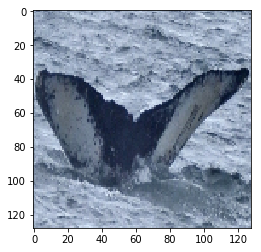

In [37]:
plt.imshow(batch["Image0"].detach().cpu().numpy()[1])